In [1]:
#Importing modules
import os
import datetime
import torch
import numpy as np

#Importing custom modules
from flow_expansion import data_gen as dg
from flow_expansion import series_expansion_laplace as sel
from flow_expansion import inn
from flow_expansion import plotting
from flow_expansion import entropy_calc as ec
from flow_expansion import geometry as geo

### Exemplary Code: Normalising Flow for Entropy Calculation and Obtaining Moments via Flow Expansion

This notebook shows how the information entropy and foremost the moments via the flow expansion can be calculated. Here, the calculations are applied to a 2D Gaussian toy model. Replacing the "samples" variable by whatever posterior distribution allows to use the code for individual analyses. Please note, that the code is written such it works in two dimensions, higher dimensions are possible but require modifications.


#### 1 Generate Toy Data
In the following, samples from a two-dimensional Gaussian with specified mean and covariance are drawn.

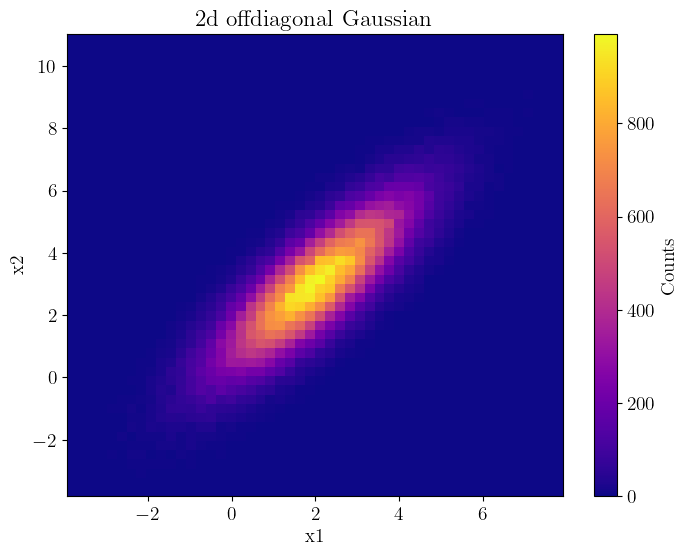

In [2]:
#Dimensionality of the example (only implemented for 2D)
N_DIM = 2

#Choose 2D-Gaussian with off-diagonal covariance matrix
EXAMPLE = 'offdiag_gaussian'
PARAMS = [np.array([2, 3]), np.array([[2, 2],[2, 3]])]

#Number of samples
NSAMPLES = 125000

#Plotting and saving
PLOT = True
SAVE = True
path_to_save = os.getcwd()+'/samples/'+EXAMPLE+'/'+str(datetime.date.today())+'/'

#Generate toy data
samples = dg.generate_data(EXAMPLE, PARAMS, N_DIM, NSAMPLES, PLOT, SAVE, path_to_save)

#### 2 Train the Normalising Flow

This code trains the invertible neural network (normalising flow). With 'vanilla_inn' we refer to a mostly unchanged implementation of the quick-start example of the FrEIA package. The hyperparameters used for training the normalising flow on the Supernova (Union 2.1) posterior can be found at the very end of this notebook.

100%|██████████| 50/50 [00:50<00:00,  1.00s/it]


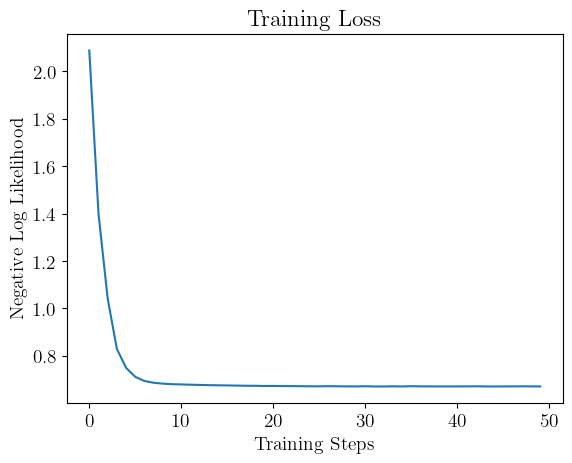

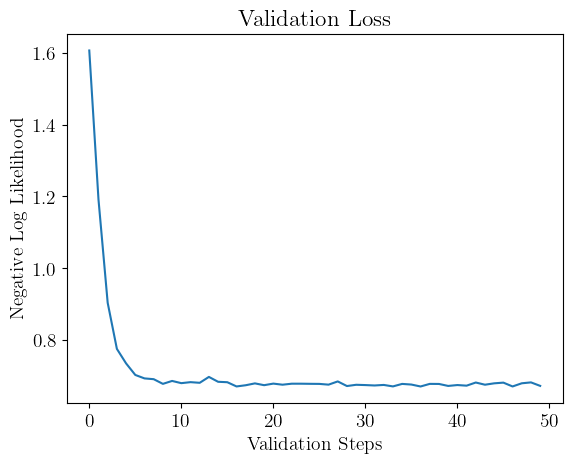

In [3]:
#Network Settings
NETWORK = 'vanilla_inn'
BATCHSIZE = 3000
N_LAYERS = 1
WIDTH_SUBNET = 64
PERMUTE_SOFT = True

#Training Settings
LEARNING_RATE = 1e-2
NUM_EPOCS = 50
DEVICE = torch.device('cpu')

#Plotting and saving
PLOT = True
SAVE = True

#Perform training
n_flow = inn.train_inn(samples, NETWORK, BATCHSIZE, N_DIM, N_LAYERS, WIDTH_SUBNET, LEARNING_RATE, NUM_EPOCS, DEVICE, PERMUTE_SOFT, PLOT, SAVE, path_to_save)

Now, the trained normalising flow can be compared to the ground truth visually. Please note, that the plotting function from "plotting" takes about three minutes.

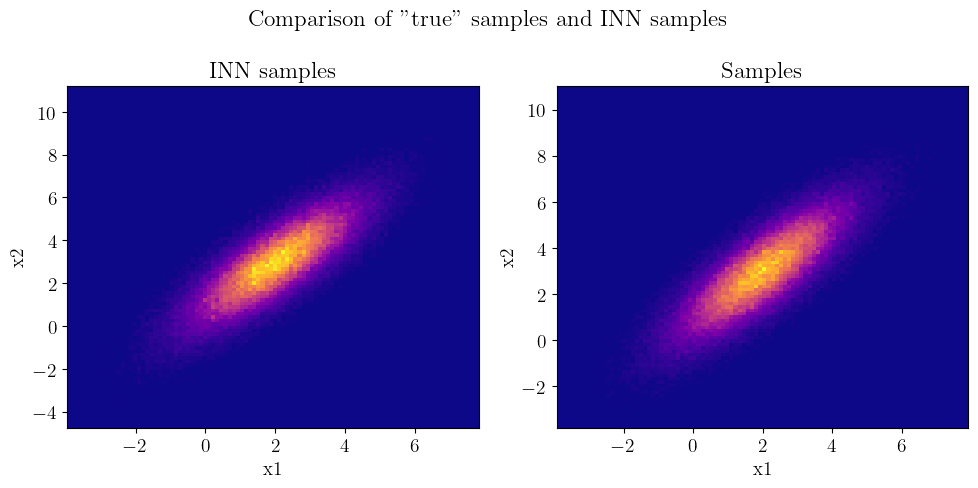

/Users/tobiasrospel/opt/anaconda3/envs/mthesis/lib/python3.11/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linestyle', 'linewidth'
  cset = contour_func(


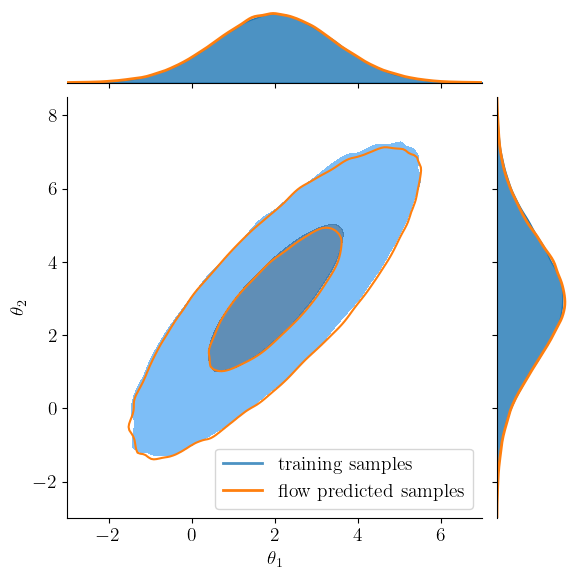

In [4]:
#Compare ground truth and learned distribution
samples_pred = inn.plot_results(n_flow, NSAMPLES, N_DIM , samples, save = False, path_to_files = "", direction = 0, NETWORK = NETWORK, visualize2d = True)

#Prettier plot with seaborn (takes about 3 min)
plotting.toy_model_plot_comparison_samples_and_prediction(samples, samples_pred, save = False, save_path = None)

#### 3 Information Entropy Calculation

The information entropy can be calculated in three different numerical manners - via the trained normalising flow, a kernel density estimate and via histogram binning. Lastly, if Gaussian toy data is chosen, it is also possible to calculate its analytical value. All values are printed out.

In [5]:
#Entropy via normalising flow
entropy_flow = ec.entropy_flow(n_flow, DEVICE, N_DIM, NSAMPLES)
print('Entropy via normalising flow: ', np.round(entropy_flow,2))

#Entropy via KDE estimate
entropy_kde = ec.entropy_kde_estimate(samples, grid_size = 100, plot = False)
print('Entropy via KDE estimate: ', np.round(entropy_kde,2))

#Entropy via histogram
entropy_hist = ec.entropy_hist_estimate(samples, bins = 20)
print('Entropy via histogram estimate: ', np.round(entropy_hist,2))

#Entropy analytical (only for 2D Gaussian)
if EXAMPLE == 'offdiag_gaussian':
    cov = PARAMS[1]
    entropy_analytical = ec.entropy_ana_gaussian(cov, N_DIM)
    print('Entropy analytical: ', np.round(entropy_analytical,2))
else:
    raise ValueError('Analytical entropy only implemented for off-diagonal Gaussian')

Entropy via normalising flow:  3.17
Entropy via KDE estimate:  3.2
Entropy via histogram estimate:  3.22
Entropy analytical:  3.18


#### 4 Moment Calculation via Flow Expansion

By using the introduced flow expansion via differentiation operators, the following code calculates the mean, covariance and in the respective dimension the skewness as well as the kurtosis. Addtionally, the ground truth values of the 2D Gaussian toy model are printed.

In [6]:
#Perform series expansion
ORDER_SERIES = 3 #order at which the series expansion is truncated
ORDER_MOMENT = 5 #order to which the moments are calculated

mean_var_skew_kurt_sel = sel.mean_var_skew_kurt_2d(n_flow, ORDER_SERIES, ORDER_MOMENT, N_DIM, NETWORK)

#Compare to the ground truth values for 2D Gaussian toy model
sel.toy_model_mean_var_skew_kurt(PARAMS)

Via flow series:
Mean:       [  2.00   2.99]
Covariance:
           [  1.98   1.94]
           [  1.94   2.87]
Skewness:   [  0.00  -0.20]
Kurtosis:   [  3.00   3.20]

Ground truth for 2D toy model:
Mean:       [  2.00   3.00]
Covariance:
           [  2.00   2.00]
           [  2.00   3.00]
Skewness:   [  0.00   0.00]
Kurtosis:   [  3.00   3.00]


#### 5 Geometry of the Transformation via the Normalising Flow

The geometric properties of the transformation learned by the normalising flow are shown. Additionally, the Jacobian as well as the area of the in red marked cell are outputs of the function. Lastly, the in the paper shown decomposition coefficients are printed out too.

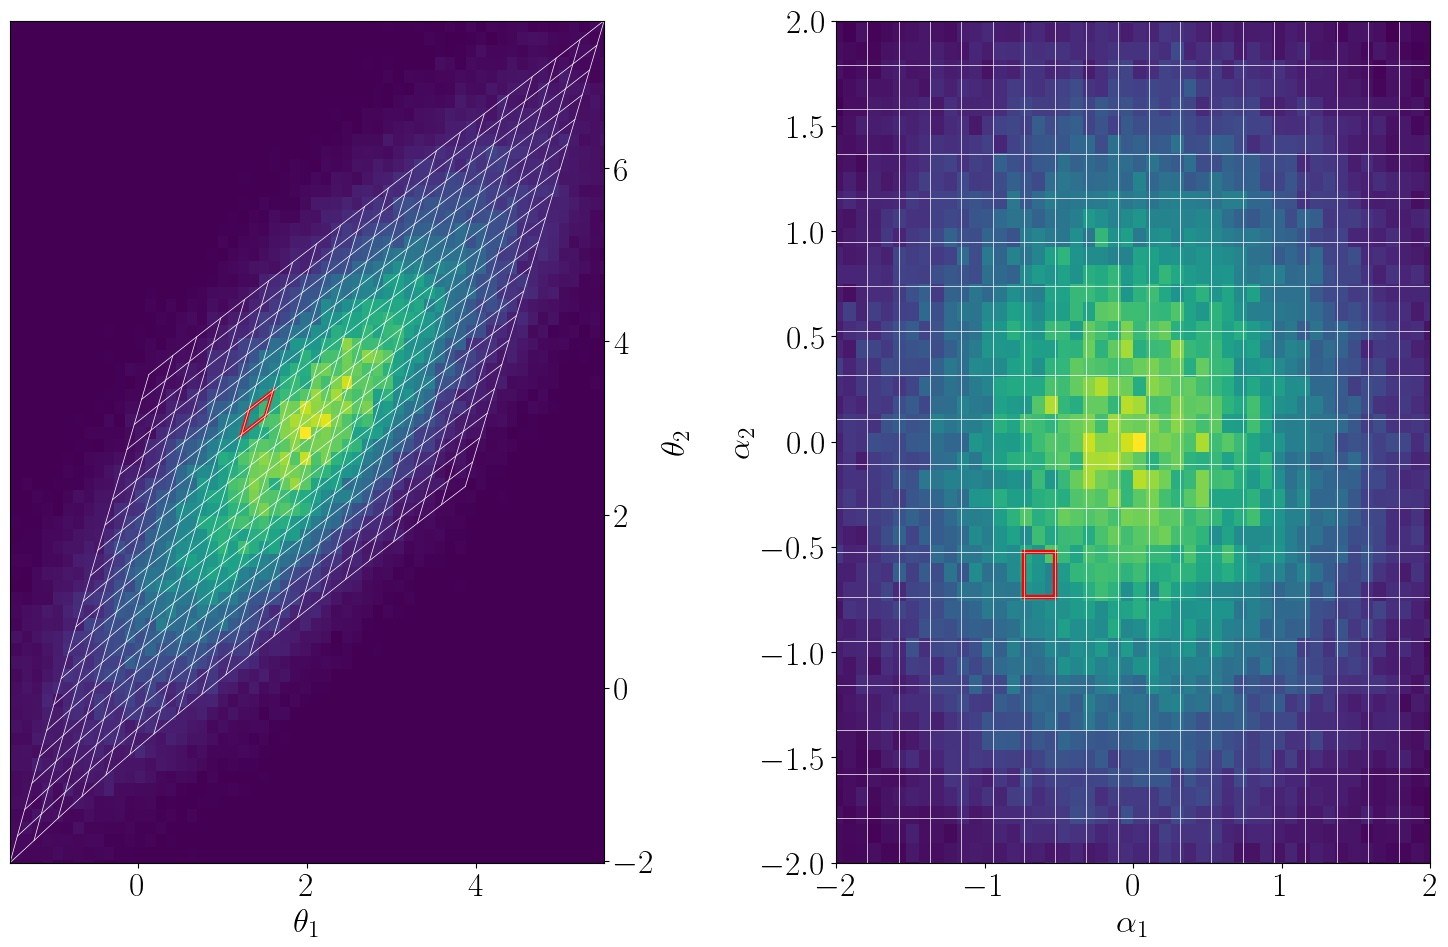

Logdet at specific box: 0.3698258049199997
Area of specific box in theta space: 0.062068887291416644
Area of specific box in alpha space: 0.04432132963988919
Jacobian at specific box: [[-1.76391848  0.61845149]
 [-0.00558448  2.37678548]]
Kappa: 0.3064335034376781, Gamma_1: -2.070351980881342, Gamma_2: 1.3416094938783483, Omega: 1.3471939786941944


In [8]:
geo.geometrical_volume_change(n_flow, path_to_save, NSAMPLES, gridsize=20, N_DIM = N_DIM)

#### Appendix: Network Settings for Union2.1 dataset (Supernova)

If one replaces the samples through posterior samples of the Supernova Union2.1 dataset, the following network settings can be used during the computations:

In [11]:
# #Entropy calculation network settings for supernova
# BATCHSIZE = 3000
# N_LAYERS = 2
# LEARNING_RATE = 1e-2 
# WIDTH_SUBNET = 128
# NUM_EPOCS = 100
# NETWORK = 'vanilla_inn'
# PERMUTE_SOFT = True

# #Flow expansion network settings for supernova (only different params new defined)
# N_LAYERS_mf = 1 
# LEARNING_RATE_mf = 1e-1
# WIDTH_SUBNET_mf = 32